# `CLOUD.jl` - 2D linear advection example

In [51]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures

## Define the physical problem

In [52]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period
CFL = 0.1

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)))
initial_data = InitialDataSine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters (energy-conservative scheme)

In [53]:
M = 4
p = 4
form = WeakConservationForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(0.0))
ode_algorithm = CarpenterKennedy2N54();

## Set up a `NodalTensor` scheme on quadrilaterals of degree `p` with `M` edges in each direction

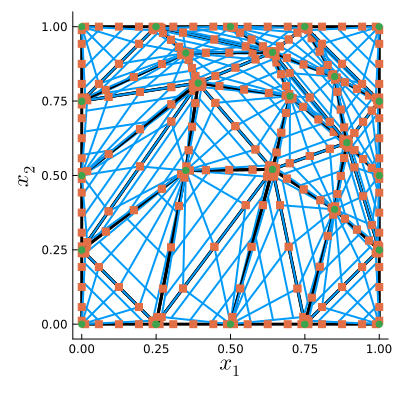

In [54]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Tri(), mapping_degree=1)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.2)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
    "results/advection_2d/", overwrite=true, clear=true)

plot(spatial_discretization, grid_connect=true, size=(400,400))

## Run the solver

In [55]:
ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T))

h = L/sqrt(reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / a

CLOUD_reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*10))))
CLOUD_print_timer()

 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            142ms /  89.2%           95.8MiB /  97.4%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual         3.58k    115ms   90.7%  32.0μs   83.6MiB   89.6%  23.9KiB
   apply operators      3.58k   97.9ms   77.5%  27.3μs   73.4MiB   78.7%  21.0KiB
     volume terms       3.58k   67.5ms   53.4%  18.8μs   57.0MiB   61.1%  16.3KiB
     facet terms        3.58k   17.0ms   13.4%  4.73μs   12.0MiB   12.8%  3.42KiB
     mul test function  3.58k   1.19ms    0.9%   332ns    112KiB    0.1%    32.0B
     mass matrix solve  3.58k    663μs    0.5%   185ns     0.00B    0.0%    0.00B
   eval num flu

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/tristanmontoya/.julia/packages/SciMLBase/AwWUI/src/integrator_interface.jl:523


## Calculate the integral L<sup>2</sup> error norm

In [56]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)

L2 error:
4.80798608355327e48


## Analyze conservation and energy dissipation

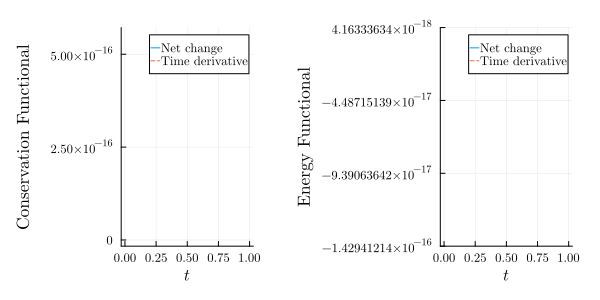

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tristanmontoya/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tristanmontoya/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191


In [57]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), ylabel="Conservation Functional")
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), ylabel="Energy Functional")
plot(p1,p2, size=(600,300),margin=5mm)

## Postprocess for VTK visualization

In [58]:
postprocess_vtk(spatial_discretization, string(results_path,"solution.vtu"), last(sol.u));

In [60]:
using UnPack
k = 5
@unpack VOL, M = ode_problem_1.p.operators[k] 
D = Tuple(inv(Matrix(M)) * VOL[m]' for m in 1:2)
x = mesh.xq[:,k]
y = mesh.yq[:,k]

25-element Vector{Float64}:
 0.7844410715110708
 0.7470296608564889
 0.6729750980122443
 0.5908638731391113
 0.5320434157944579
 0.6813450214740316
 0.6583423007870057
 0.6128092295956012
 0.5623224519526706
 0.5261561987345106
 0.5303728476354208
 0.528469977483765
 0.5247033133894512
 0.5205268603716908
 0.5175350541117955
 0.37940067379681003
 0.39859765418052395
 0.4365973971833009
 0.47873126879071115
 0.5089139094890804
 0.2763046237597705
 0.30991029411104076
 0.37643152876665764
 0.4501898476042704
 0.5030266924291333

In [63]:
[D[1] * x D[2] * y]

25×2 Matrix{Float64}:
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0

In [71]:
using LinearAlgebra: Diagonal
@unpack Λ_ref, J_ref = reference_approximation.reference_mapping
@unpack D = reference_approximation
@unpack rstq = reference_approximation.reference_element
d = 2
Dξ = Tuple(sum(Diagonal(Λ_ref[:,m,n]./J_ref)*Matrix(D[m]) for m in 1:d) for n in 1:d)

([-5.067040595654553 0.0 … 0.0 0.0; 0.0 -5.890262945926428 … 0.0 0.0; … ; 0.0 0.0 … 18.302938293678395 0.0; 0.0 0.0 … 0.0 88.73324449735738], [-6.23769526465968 7.836478943424693 … 0.0 0.0; -1.6332553776604262 0.014303837766101002 … 0.0 0.0; … ; 0.0 0.0 … 18.3473849104762 0.7385862545703638; 0.0 0.0 … -7.010116273283879 88.94872315177442])

In [72]:
Dξ[1] * rstq[1]

25-element Vector{Float64}:
 1.0000000000000002
 1.000000000000001
 1.0000000000000013
 1.0000000000000056
 0.9999999999999959
 1.0000000000000002
 1.0
 1.0000000000000002
 1.0000000000000009
 1.0000000000000075
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000004
 1.0000000000000062
 1.0000000000000007
 1.000000000000001
 1.000000000000001
 1.0000000000000016
 1.0000000000000078
 1.0000000000000009
 0.9999999999999999
 1.0000000000000013
 1.0000000000000024
 1.0000000000000047